---
title: "Digital Waveguide Models, Part 1"
author: "Brian Cruz"
date: "2025-12-06"
categories: sound synthesis, mathematics
---


::: {.content-hidden}
# HIDDEN: Frontend mattter
:::

In [2]:
# | echo: false
# | output: false

# We want to initialize Plotly's notebook mode so that it is rendered properly in Quarto.
# Otherwise, we may see the message
#   Unable to display output for mime type(s): application/vnd.plotly.v1+json

import plotly.offline as py

py.init_notebook_mode(connected=True)


::: {.content-hidden}
# HIDDEN: Article START
:::

In [ ]:
# Create a dataclass for the initial conditions of the waveguide

from dataclasses import dataclass
import numpy as np


@dataclass
class WaveguideStates:
    positions: np.ndarray
    velocities: np.ndarray
    time_samples: int = 0
    # linear_density_kg_per_m: float = 0.01  # kg/m
    linear_density_kg_per_m: float = 0.0081 / 4  # kg/m
    tension_N: float = 186.650244  # Newtons
    length_m: float = 0.69  # meters
    simulation_sampling_rate_hz: int = 192000  # Hz

    @property
    def theoretical_wave_speed(self) -> float:
        return np.sqrt(self.tension_N / self.linear_density_kg_per_m)

    @property
    def dx(self) -> float:
        return self.length_m / (self.positions.shape[1] - 1)

    @property
    def c(self) -> float:
        return self.theoretical_wave_speed

    @property
    def dt(self) -> float:
        # return self.dx / self.c / 4  # CFL condition with safety factor
        return 1.0 / self.simulation_sampling_rate_hz

    def verify_cfl_condition(self) -> bool:
        cfl_number = (self.c * self.dt) / self.dx
        if cfl_number <= 1.0:
            raise ValueError(
                f"CFL condition not met: c*dt/dx = {cfl_number} > 1.0. c={self.c}, dt={self.dt}, dx={self.dx}"
            )
        return True

    @property
    def theoretical_fundamental_frequency(self) -> float:
        return self.c / (2 * self.length_m)

    def __init__(
        self,
        positions: np.ndarray,
        velocities: np.ndarray,
        time: float = 0.0,
        verify_cfl: bool = False,
    ):
        # If positions and velocities are 1D arrays, convert them to 2D column vectors
        if positions.ndim == 1:
            positions = positions[np.newaxis, :]
        if velocities.ndim == 1:
            velocities = velocities[np.newaxis, :]

        self.positions = positions
        self.velocities = velocities
        self.time = time
        if verify_cfl:
            self.verify_cfl_condition()
        if self.positions.shape != self.velocities.shape:
            raise ValueError(
                "Positions and velocities must have the same shape."
                f"Got {self.positions.shape} and {self.velocities.shape}."
            )

    @classmethod
    def initialize(cls, length: int, time: float) -> "WaveguideStates":
        positions = np.zeros((1, length), dtype=np.float64)
        velocities = np.zeros((1, length), dtype=np.float64)
        return cls(positions=positions, velocities=velocities, time=time)

    @classmethod
    def initial_pluck(
        cls, length: int, pluck_position_p: float, pluck_amplitude: float
    ) -> "WaveguideStates":
        positions = np.zeros(length)
        velocities = np.zeros(length)

        pluck_position = int(pluck_position_p * (length - 1))

        # Create a triangular pluck shape
        for i in range(length):
            if i < pluck_position:
                positions[i] = (pluck_amplitude / pluck_position) * i
            else:
                positions[i] = pluck_amplitude - (
                    pluck_amplitude / (length - pluck_position)
                ) * (i - pluck_position)
        return cls(positions=positions, velocities=velocities)

    @classmethod
    def initial_strike(
        cls,
        length: int,
        strike_position_p: float,
        strike_amplitude: float,
        strike_width: int,
    ) -> "WaveguideStates":
        positions = np.zeros(length)
        velocities = np.zeros(length)
        strike_position = int(strike_position_p * (length - 1))

        # Create a rectangular strike shape
        start = max(0, strike_position - strike_width // 2)
        end = min(length, strike_position + strike_width // 2)
        velocities[start:end] = strike_amplitude

        return cls(positions=positions, velocities=velocities)

    @classmethod
    def initial_standing_wave(
        cls, length: int, harmonic_amplitudes: dict[int, float] | None = None, **kwargs
    ) -> "WaveguideStates":
        positions = np.zeros(length)
        velocities = np.zeros(length)

        x = np.linspace(0, np.pi, length)

        if harmonic_amplitudes is not None:
            for harmonic, amplitude in harmonic_amplitudes.items():
                positions += amplitude * np.sin(harmonic * x)

        return cls(positions=positions, velocities=velocities, **kwargs)

    def plot(
        self,
        index: int = -1,
        height: int = 400,
        y_range: tuple[float, float] = (-0.06, 0.06),
    ) -> None:
        import plotly.graph_objects as go

        fig = go.Figure()
        fig.add_trace(
            go.Scatter(y=self.positions[index], mode="lines", name="Positions")
        )
        fig.add_trace(
            go.Scatter(y=self.velocities[index], mode="lines", name="Velocities")
        )
        fig.update_layout(
            title="Waveguide State",
            xaxis_title="Sample Index",
            yaxis_title="Amplitude",
            legend_title="Legend",
            height=height,
            yaxis=dict(range=y_range),
        )
        fig.show()

    def plot_animation(
        self,
        height: int = 400,
        y_range: tuple[float, float] = (-0.08, 0.08),
        interval: int = 100,
        skip_frames: int = 50,
        num_frames: int | None = 100,
    ) -> None:
        import plotly.graph_objects as go

        positions = self.positions[::skip_frames]
        velocities = self.velocities[::skip_frames]

        if num_frames:
            positions = positions[:num_frames]
            velocities = velocities[:num_frames]

        fig = go.Figure(
            data=[
                go.Scatter(y=positions[0], mode="lines", name="Positions"),
                go.Scatter(y=velocities[0], mode="lines", name="Velocities"),
            ],
            layout=go.Layout(
                title="Waveguide State Animation",
                xaxis_title="Sample Index",
                yaxis_title="Amplitude",
                legend_title="Legend",
                height=height,
                yaxis=dict(range=y_range),
                updatemenus=[
                    dict(
                        type="buttons",
                        buttons=[
                            dict(
                                label="Play",
                                method="animate",
                                args=[
                                    None,
                                    {
                                        "frame": {"duration": interval, "redraw": True},
                                        "fromcurrent": True,
                                        "transition": {
                                            "duration": 0,
                                            #    "easing": "cubic"
                                        },
                                    },
                                ],
                            ),
                            dict(
                                label="Pause",
                                method="animate",
                                args=[
                                    [None],
                                    {
                                        "frame": {"duration": 0, "redraw": False},
                                        "mode": "immediate",
                                        "transition": {"duration": 0},
                                    },
                                ],
                            ),
                        ],
                    )
                ],
            ),
            frames=[
                go.Frame(
                    data=[
                        go.Scatter(y=positions[k], mode="lines"),
                        go.Scatter(y=velocities[k], mode="lines"),
                    ],
                    name=f"frame{k}",
                )
                for k in range(positions.shape[0])
            ],
        )

        fig.update_layout(
            sliders=[
                dict(
                    steps=[
                        dict(
                            method="animate",
                            args=[
                                [f"frame{k}"],
                                {
                                    "frame": {"duration": interval, "redraw": True},
                                    "mode": "immediate",
                                },
                            ],
                            label=f"{k}",
                        )
                        for k in range(positions.shape[0])
                    ],
                    transition={"duration": 0},
                    x=0,
                    y=0,
                    currentvalue=dict(
                        font=dict(size=12), prefix="Frame: ", visible=True
                    ),
                    len=1.0,
                )
            ]
        )

        fig.show()

    def get_audio(
        self,
        string_position: float = 0.43,
    ) -> np.ndarray:
        string_position_int = int(string_position * (self.positions.shape[1] - 1))

        audio = np.array(
            [position[string_position_int] for position in self.positions],
            dtype=np.float32,
        )

        return audio

    def calculate_fundamental_frequency(self, method: str = "zero_crossing") -> float:
        audio = self.get_audio(string_position=0.43)
        audio -= np.mean(audio)  # Remove DC offset

        if method == "zero_crossing":
            zero_crossings = np.where(np.diff(np.sign(audio)))[0]
            if len(zero_crossings) < 2:
                return 0.0  # Not enough zero crossings to calculate frequency
            periods = np.diff(zero_crossings)
            average_period = np.mean(periods)
            sampling_rate = 1.0 / self.dt
            fundamental_frequency = sampling_rate / average_period
            return fundamental_frequency
        else:
            raise ValueError(f"Unknown method: {method}")

    def play_audio(
        self,
        sample_rate: int = 48000,
        duration: float | None = None,
        string_position: float = 0.43,
    ) -> None:
        from IPython.display import Audio
        import IPython.display as ipd
        from scipy.signal import butter, lfilter, resample_poly

        audio = self.get_audio(string_position=string_position)

        # Check that the sampling rate of the simulation is an integer multiple of the desired sample rate
        if self.simulation_sampling_rate_hz % sample_rate != 0:
            raise ValueError(
                f"Simulation sampling rate ({simulation_sampling_rate} Hz) must be an integer multiple of the desired sample rate ({sample_rate} Hz)."
            )

        ratio = simulation_sampling_rate // sample_rate
        print(
            f"Resampling audio by a factor of {ratio} from {simulation_sampling_rate} Hz to {sample_rate} Hz."
        )

        audio = resample_poly(audio, up=1, down=ratio)

        ipd.display(ipd.Audio(audio, rate=sample_rate), autoplay=True)
        # audio_data = self.positions.flatten()
        return Audio(
            data=audio,
            rate=sample_rate,
            autoplay=False,
        )


# standing_wave_state.positions.shape
# standing_wave_state.plot()


def simulate_waveguide(
    initial_state: WaveguideStates,
    num_steps: int,
    c: float = 1.0,
    dx: float = 1.0,
    # dt: float = 0.1,
    verlet: bool = True,
) -> WaveguideStates:
    length = len(initial_state.positions[-1])
    position = initial_state.positions[-1].copy()
    velocity = initial_state.velocities[-1].copy()
    time = initial_state.time
    dt = initial_state.dt

    positions_to_append = []
    velocities_to_append = []

    for step in range(num_steps):
        new_position = position.copy()
        new_velocity = velocity.copy()

        for i in range(1, length - 1):
            # new_velocity[i] += (c**2 * dt / dx**2) * (
            #     position[i + 1] - 2 * position[i] + position[i - 1]
            # )
            c = initial_state.theoretical_wave_speed
            dx = initial_state.dx
            dt = initial_state.dt
            new_velocity[i] += (c**2 * dt / dx**2) * (
                position[i + 1] - 2 * position[i] + position[i - 1]
            )
        # Update position using velocity and acceleration (Verlet integration)
        new_position += new_velocity * dt
        if verlet:
            new_position += (
                0.5 * (new_velocity - velocity) * dt**2
            )  # Verlet term. Seems to add a LP filter

        position = new_position
        velocity = new_velocity
        time += dt

        # if step % 100 == 0:
        # print(f"Step {step}/{num_steps}")
        positions_to_append.append(position.copy())
        velocities_to_append.append(velocity.copy())

    new_wave_guide_states = WaveguideStates(
        positions=np.vstack([initial_state.positions] + positions_to_append),
        velocities=np.vstack([initial_state.velocities] + velocities_to_append),
        time=time,
    )

    return new_wave_guide_states


# Example usage
# standing_wave_state.plot()

# # plucked_state = WaveguideStates.initial_pluck(
# #     length=N, pluck_position_p=0.3, pluck_amplitude=0.05
# # )
# # plucked_state.plot()


# # struck_state = WaveguideStates.initial_strike(
# #     length=N, strike_position_p=0.5, strike_amplitude=0.005, strike_width=10
# # )
# # struck_state.plot()

N = 100
standing_wave_state = WaveguideStates.initial_standing_wave(
    length=N,
    harmonic_amplitudes={
        1: 0.03,
        # 2: 0.02,
        # 3: 0.03,
    },
    verify_cfl=False,
)


output = simulate_waveguide(standing_wave_state, num_steps=100000, verlet=False)
# output.plot_animation()
output.play_audio()
print(1.0 / output.dt)
print(
    "Calculated fundamental frequency (Hz):", output.calculate_fundamental_frequency()
)
print(
    "Theoretical fundamental frequency (Hz):",
    standing_wave_state.theoretical_fundamental_frequency,
)

from IPython.display import Audio

xx = np.linspace(0, 1, 44100)
yy = 0.05 * np.sin(2 * np.pi * 440 * xx)
Audio(data=yy, rate=44100, autoplay=True)
# len(yy)
# xx

Resampling audio by a factor of 4 from 192000 Hz to 48000 Hz.


192000.0
Calculated fundamental frequency (Hz): 439.98190863862504
Theoretical fundamental frequency (Hz): 220.0


In [4]:
(output.c**2 * output.dt / output.dx**2)

np.float64(6050.0)

In [23]:
audio = output.get_audio()

# calculate the frequencies of all harmonics

# frequencies = [n * (1 / (2 * N)) * np.sqrt(standing_wave_state.tension / standing_wave_state.linear_density) for n in range(1, 11)]
# frequencies

# get f_0 using zero crossing method
# d


def zero_crossing_frequency_rad_s(audio: np.ndarray) -> float:
    zero_crossings = np.where(np.diff(np.sign(audio)))[0]
    if len(zero_crossings) < 2:
        return 0.0
    periods = np.diff(zero_crossings)
    average_period = np.mean(periods)
    frequency_rad_s = 2 * np.pi / average_period
    return frequency_rad_s


fundamental_freq_rad_s = zero_crossing_frequency_rad_s(audio)
fundamental_freq_rad_s * (96000 / (2 * np.pi))  # convert to Hz
print(fundamental_freq_rad_s * (96000 / (2 * np.pi)))

# Get amplitude of each harmonic using FFT
fft_result = np.fft.fft(audio)
fft_magnitudes = np.abs(fft_result)
fft_frequencies = np.fft.fftfreq(len(audio), d=1 / 96000)

harmonic_amplitudes = {}
for n in range(1, 11):
    target_freq = n * (fundamental_freq_rad_s * (96000 / (2 * np.pi)))
    idx = (np.abs(fft_frequencies - target_freq)).argmin()
    harmonic_amplitudes[n] = fft_magnitudes[idx]

harmonic_amplitudes


399.71907294070434


{1: np.float32(1.2029288),
 2: np.float32(0.4547315),
 3: np.float32(0.28936),
 4: np.float32(0.21347272),
 5: np.float32(0.16959088),
 6: np.float32(0.14082116),
 7: np.float32(0.12042618),
 8: np.float32(0.105265014),
 9: np.float32(0.09352227),
 10: np.float32(0.08413695)}

In [ ]:
audio = np.array(
    [position[42] for position in output.positions],
    dtype=np.float32,
)

IndexError: index 42 is out of bounds for axis 0 with size 25

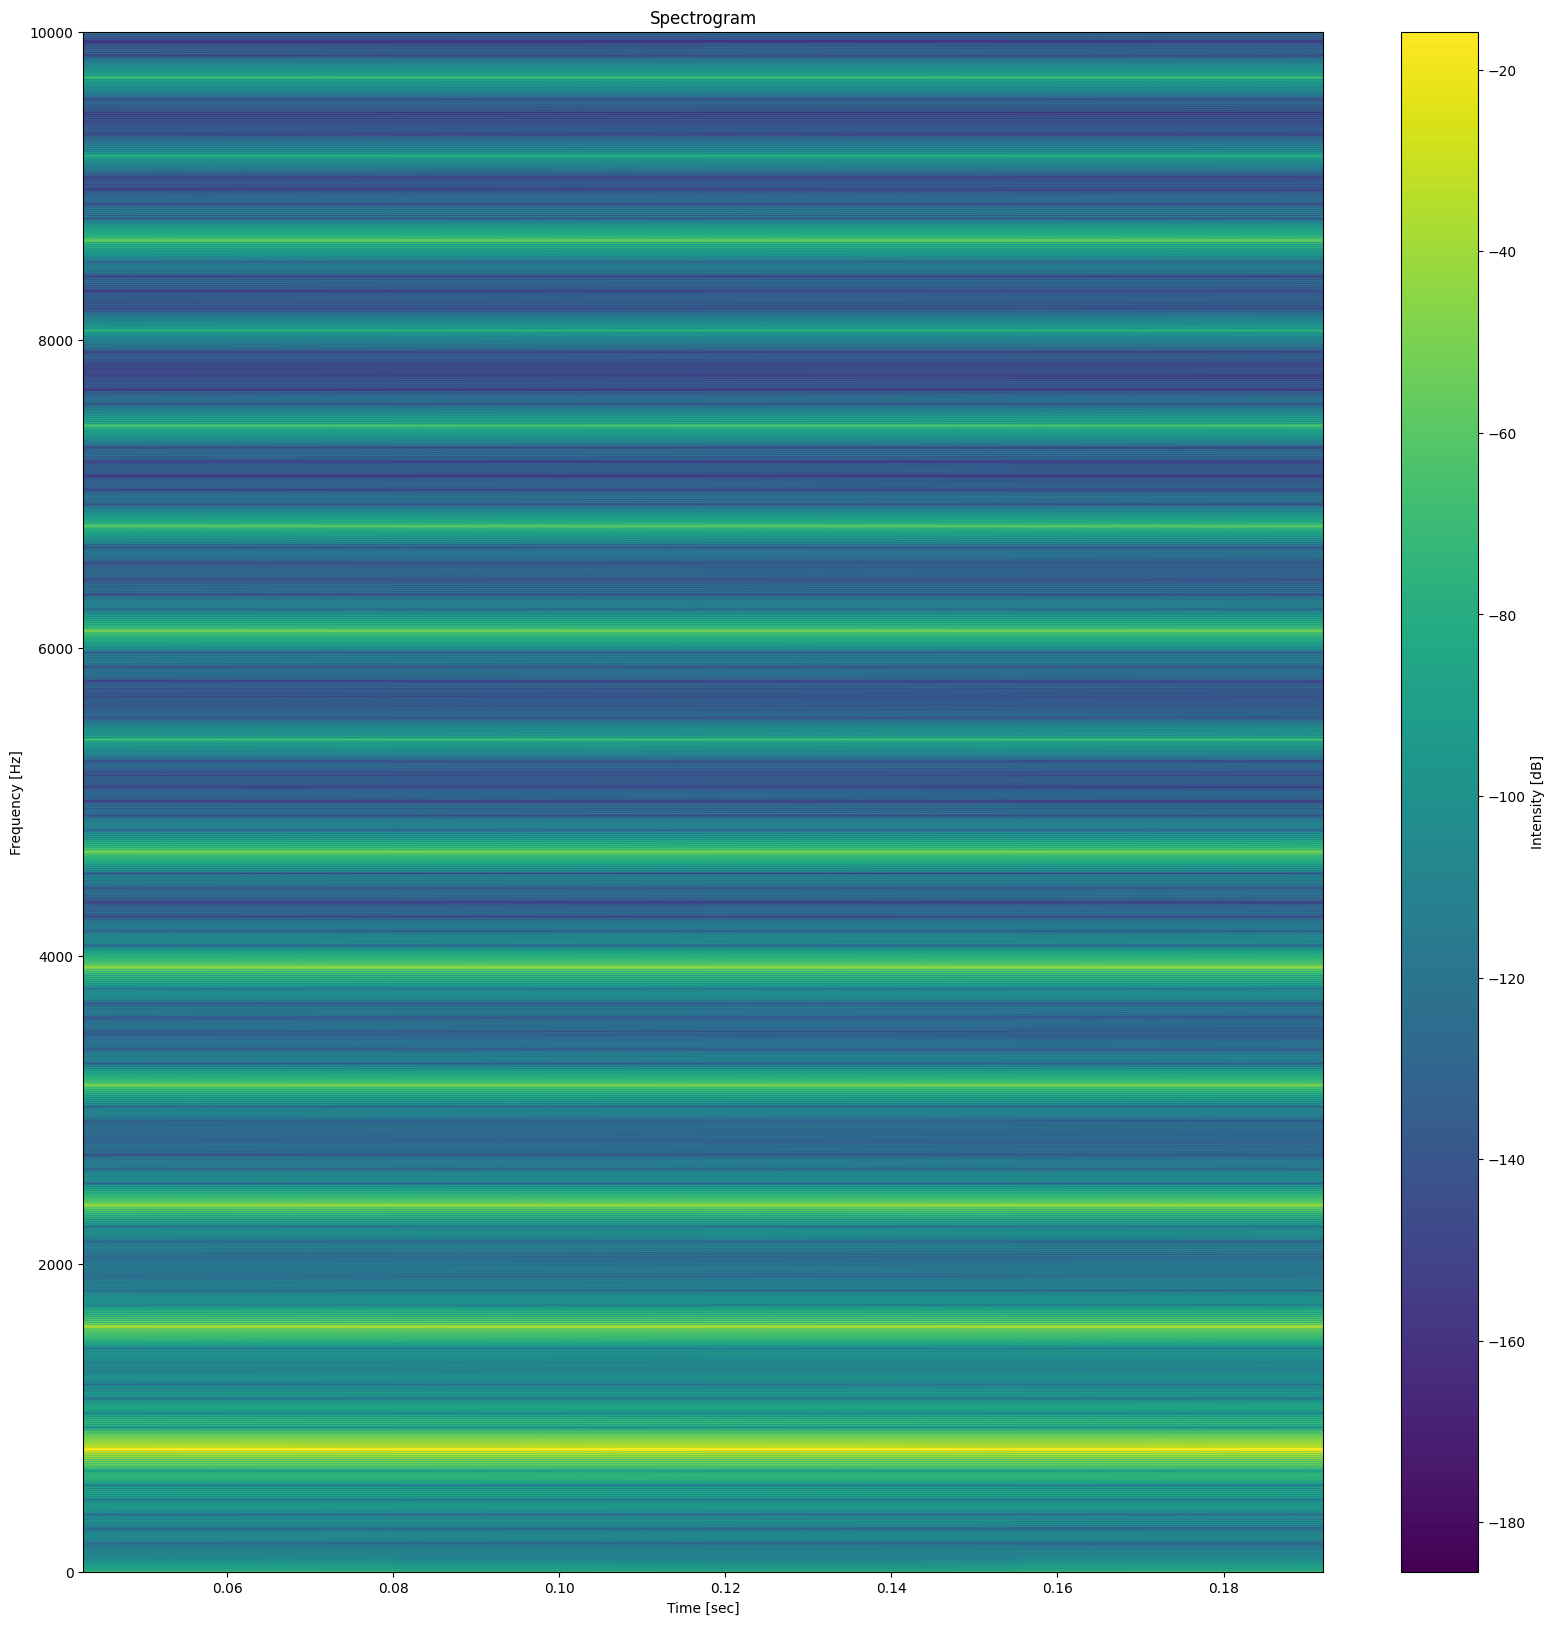

Estimated fundamental frequency: 799.8046875 Hz


In [27]:
audio = np.array(
    [position[11] for position in output.positions],
    dtype=np.float32,
)
from IPython.display import Audio


# show spectrogram
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# downsample audio for better visualization
from scipy.signal import resample_poly

audio = resample_poly(audio, up=1, down=16)

# normalize audio
audio = audio / np.max(np.abs(audio))

fs = 24000

display(Audio(audio, rate=fs))

audio = audio[:22000]

# show spectrogram
frequencies, times, Sxx = spectrogram(
    audio, fs=fs, nperseg=2048, noverlap=None, nfft=16384
)
# width=512, noverlap=256)
plt.figure(figsize=(20, 20))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading="gouraud")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.title("Spectrogram")
plt.colorbar(label="Intensity [dB]")
plt.ylim(0, 10000)  # limit y axis to 2000 Hz
plt.show()

# calculate fundamental frequency from spectrogram
import numpy as np

fundamental_freq = frequencies[np.argmax(Sxx, axis=0)]
print("Estimated fundamental frequency:", np.median(fundamental_freq), "Hz")

# create sin wave at fundamental frequency
t = np.linspace(0, len(audio) / fs, len(audio))
sine_wave = 0.05 * np.sin(2 * np.pi * np.median(fundamental_freq) * t)
# play sine wave
from IPython.display import display

display(Audio(sine_wave, rate=fs))


::: {.content-hidden}
# HIDDEN: Article END
:::

::: {.content-hidden}
# This entire markdown section will be hidden.
:::

In [4]:
# | echo: false
# | output: false
print("This code and its output will be hidden.")

This code and its output will be hidden.
